In [1]:
import pandas as pd
import pickle
#mount to google drive
from google.colab import drive
drive.mount('/content/drive')

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch, pandas as pd, numpy as np
import random

import os, math, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedGroupKFold

import os, json, math, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

Mounted at /content/drive


In [2]:
df_balanced = pd.read_pickle("/content/drive/MyDrive/anual proj deep learning/merged_with_sent_embeddings_12aug25_qwen06b.pkl")
df_balanced= df_balanced[['sub', 'episode', 'segment', 'df_idx', 'arousal', 'is_augmented',
                          'valence','interest','bert_cls_embedding',
                          'bert_mean_embedding', 'sen_embedding_qwen0.6b']]
df_no_aug = df_balanced[df_balanced['is_augmented'] == False ]



# Re-Balance

In [3]:
# import numpy as np
# import pandas as pd

# def cap_augmented_in_3to5_rectangle(df, cap_per_class=2000, seed=42):
#     """
#     Downsample ONLY augmented rows within the rectangle:
#       is_augmented == True AND valence in [3,5] AND arousal in [3,5]
#     so that final counts per class (valence=3/4/5 and arousal=3/4/5) are <= cap_per_class.
#     Two passes: (1) cap by valence, (2) cap by arousal.
#     """
#     rng = np.random.RandomState(seed)
#     df = df.copy()

#     # Ensure numeric (and drop NAs in these keys if exist)
#     df['valence'] = pd.to_numeric(df['valence'], errors='coerce')
#     df['arousal'] = pd.to_numeric(df['arousal'], errors='coerce')
#     df = df.dropna(subset=['valence', 'arousal'])
#     df['valence'] = df['valence'].astype(int)
#     df['arousal'] = df['arousal'].astype(int)

#     def rect_mask(d):
#         return (
#             d['is_augmented'].astype(bool) &
#             d['valence'].between(2, 5) &
#             d['arousal'].between(3, 6)
#         )

#     # ---- Pass A: cap by VALENCE for classes 3,4,5 ----
#     for v in (2, 3, 4, 5):
#         total_v = (df['valence'] == v).sum()
#         excess = max(0, total_v - cap_per_class)
#         if excess > 0:
#             candidates = df.index[rect_mask(df) & (df['valence'] == v)]
#             if len(candidates) > 0:
#                 n_remove = min(excess, len(candidates))
#                 drop_idx = rng.choice(candidates, size=n_remove, replace=False)
#                 df = df.drop(drop_idx)

#     # ---- Pass B: cap by AROUSAL for classes 3,4,5 ----
#     for a in (3, 4, 5, 6):
#         total_a = (df['arousal'] == a).sum()
#         excess = max(0, total_a - cap_per_class)
#         if excess > 0:
#             candidates = df.index[rect_mask(df) & (df['arousal'] == a)]
#             if len(candidates) > 0:
#                 n_remove = min(excess, len(candidates))
#                 drop_idx = rng.choice(candidates, size=n_remove, replace=False)
#                 df = df.drop(drop_idx)

#     return df

# # === usage ===
# df_capped = cap_augmented_in_3to5_rectangle(df_balanced, cap_per_class=2000, seed=42)

# # # Quick sanity checks (optional):
# # print("Valence counts (post-cap):")
# # print(df_capped['valence'].value_counts().sort_index())
# # print("\nArousal counts (post-cap):")
# # print(df_capped['arousal'].value_counts().sort_index())



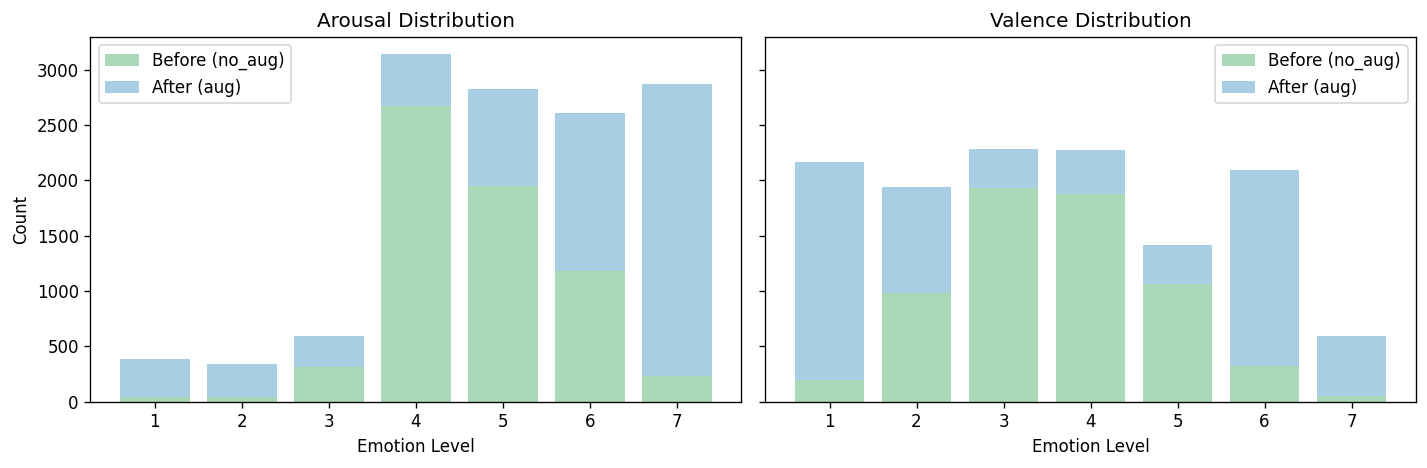

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# הכנה - ספירות
levels = np.arange(1, 8)

bef_val = (df_balanced.loc[df_balanced['is_augmented'] == False, 'valence']
           .astype(int).value_counts().reindex(levels, fill_value=0))
bef_aro = (df_balanced.loc[df_balanced['is_augmented'] == False, 'arousal']
           .astype(int).value_counts().reindex(levels, fill_value=0))

aft_val = df_capped['valence'].astype(int).value_counts().reindex(levels, fill_value=0)
aft_aro = df_capped['arousal'].astype(int).value_counts().reindex(levels, fill_value=0)

aug_val = np.maximum(aft_val - bef_val, 0)
aug_aro = np.maximum(aft_aro - bef_aro, 0)

# גרף
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# --- Arousal subplot ---
axes[0].bar(levels, bef_aro, color="#88c999", alpha=0.7, label="Before (no_aug)")
axes[0].bar(levels, aug_aro, bottom=bef_aro, color="#a6cee3", alpha=0.99, label="After (aug)")
axes[0].set_title("Arousal Distribution")
axes[0].set_xlabel("Emotion Level")
axes[0].set_ylabel("Count")
axes[0].legend()

# --- Valence subplot ---
axes[1].bar(levels, bef_val, color="#88c999", alpha=0.7, label="Before (no_aug)")
axes[1].bar(levels, aug_val, bottom=bef_val, color="#a6cee3", alpha=0.99, label="After (aug)")
axes[1].set_title("Valence Distribution")
axes[1].set_xlabel("Emotion Level")
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
balance_count = df_balanced[df_balanced['is_augmented']==False]['sub'].value_counts()
capped_count = df_capped['sub'].value_counts()
#create one df with both value counts
df_count = pd.DataFrame({'original_count': balance_count, 'after_augmentation_count': capped_count})
df_count

,original_count,after_augmentation_count
sub,,
5,576,1205
6,515,1087
7,580,747
8,797,1510
12,533,2029
15,680,878
17,623,1476
18,790,1467
21,641,1145


#  Demonstrate generalization effect

We will train model by one subject's data only and then test it with 2 sets. First is same subject's set and the second set will be other person's texts. We want to show that there is a problem to generalize with a small sample of diferent subjects (n=12 in full data). That way, training with n=8 and test on n=4 will decerease preformence

Train subject: 12 | Other subject: 8
Train subject: 12 | Other subject: 8


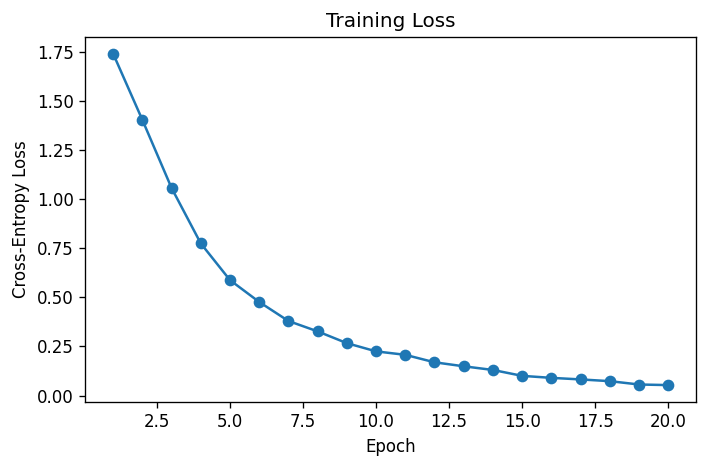

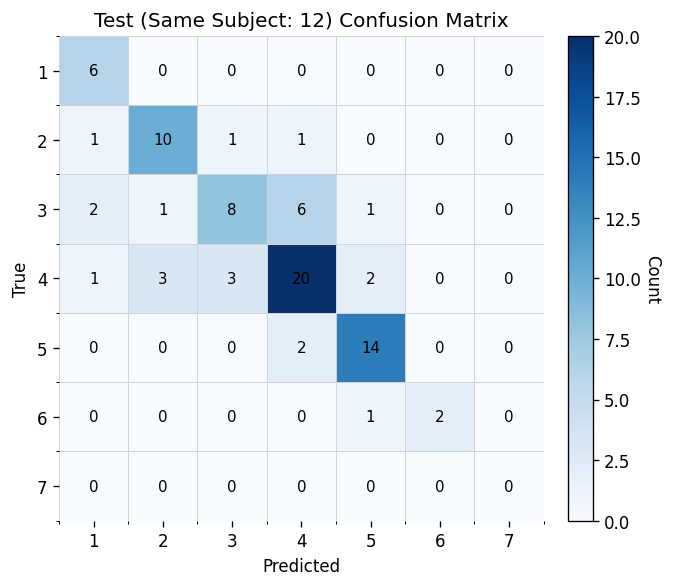

Test (Same Subject: 12)  Acc=0.706 | BalAcc=0.741 | W-Acc=0.687 | W-F1=0.698


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


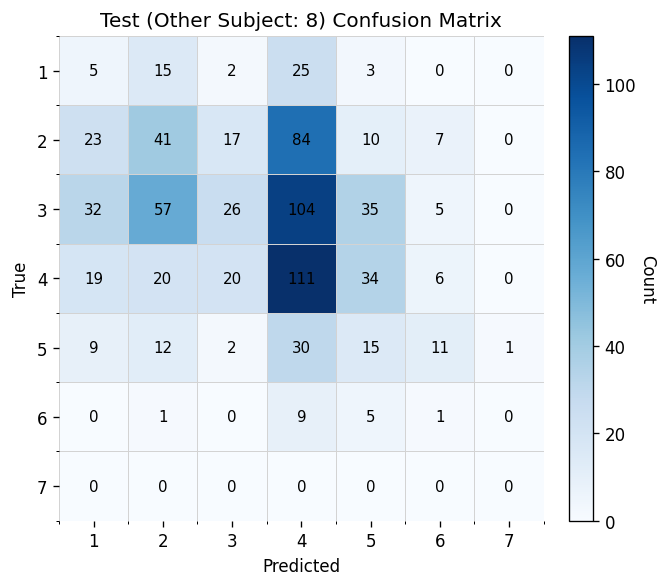

Test (Other Subject: 8)  Acc=0.250 | BalAcc=0.201 | W-Acc=0.254 | W-F1=0.233
                 acc  bal_acc  w_acc   f1_w
Same Subject   0.706    0.741  0.687  0.698
Other Subject  0.250    0.201  0.254  0.233


In [ ]:
# ===========================
# One-subject training, two tests (same vs other) + visualizations
# ===========================
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             confusion_matrix)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ===== Config =====
EMB_COL = 'sen_embedding_qwen0.6b'
AUG_COL = 'is_augmented'            # column that marks augmentations: True/False
USE_AUG_IN_TRAIN = True             # allow augmented samples in training
ENFORCE_NON_AUG_IN_TEST = True      # forbid augmented samples in test sets
TRAIN_FRAC = 0.8
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 20
HIDDEN = 256
DROPOUT = 0.2

df = df_capped.copy()
df = df.dropna(subset=['valence','sub',EMB_COL]).copy()
df['valence'] = pd.to_numeric(df['valence'], errors='coerce')
df = df.dropna(subset=['valence'])
df['valence'] = df['valence'].astype(int)

# ===== Helpers =====
def ensure_numpy_embeddings(series):
    out = []
    for x in series:
        if isinstance(x, np.ndarray):
            arr = x
        elif isinstance(x, (list, tuple)):
            arr = np.array(x)
        else:
            arr = np.array(ast.literal_eval(x))
        out.append(arr.astype(np.float32))
    return pd.Series(out, index=series.index)


df[EMB_COL] = ensure_numpy_embeddings(df[EMB_COL])




def pick_two_subjects(df, min_rows_other=100):
    counts = df['sub'].value_counts()
    sub_train = counts.index[0]
    sub_other = None
    for s in counts.index[1:]:
        if counts[s] >= min_rows_other:
            sub_other = s
            break
    if sub_other is None and len(counts.index) > 1:
        sub_other = counts.index[1]
    elif sub_other is None:
        raise ValueError("Need at least two subjects.")
    return sub_train, sub_other

sub_train, sub_other = pick_two_subjects(df, min_rows_other=100)
print(f"Train subject: {sub_train} | Other subject: {sub_other}")

class EmbDataset(Dataset):
    def __init__(self, X_list, y):
        self.X = X_list
        self.y = y.astype(int).values  # labels 1..7

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx])
        y = torch.tensor(self.y[idx] - 1)  # map 1..7 -> 0..6
        return x, y

def df_to_dataset(d, emb_col):
    return EmbDataset(d[emb_col].tolist(), d['valence'])

class MLP(nn.Module):
    def __init__(self, in_dim, hidden=256, dropout=0.2, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden//2, num_classes)
        )
    def forward(self, x):
        return self.net(x)

def train_model(model, loader, epochs=20, lr=1e-3):
    crit = nn.CrossEntropyLoss()
    opt  = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    for ep in range(1, epochs+1):
        model.train()
        total = 0.0
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()
            total += loss.item() * xb.size(0)
        losses.append(total / len(loader.dataset))
    return losses

def plot_loss(losses):
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(losses)+1), losses, marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Cross-Entropy Loss")
    plt.tight_layout()
    plt.show()

@np.vectorize
def _to17(v): return int(v) + 1

def evaluate_and_plot(model, loader, class_weights, title_prefix=""):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb.to(DEVICE))
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            ys.append(yb.numpy())
            ps.append(pred)
    y = np.concatenate(ys)  # 0..6
    p = np.concatenate(ps)  # 0..6

    # --- metrics ---
    acc = accuracy_score(y, p)
    bal_acc = balanced_accuracy_score(y, p)

    # weighted by class distribution (based on all data)
    sw = np.array([class_weights[yy] for yy in y])
    w_acc = accuracy_score(y, p, sample_weight=sw)
    f1_w = f1_score(y, p, average='weighted')

    # --- confusion matrix (labels 1..7) ---
    cm = confusion_matrix(_to17(y), _to17(p), labels=[1,2,3,4,5,6,7])

    fig, ax = plt.subplots(figsize=(6,5), facecolor='white')
    im = ax.imshow(cm, cmap='Blues', interpolation='nearest', aspect='equal')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]),
                    ha='center', va='center', color='black', fontsize=9)

    ax.set_title(f"{title_prefix} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(7)); ax.set_yticks(range(7))
    ax.set_xticklabels([1,2,3,4,5,6,7])
    ax.set_yticklabels([1,2,3,4,5,6,7])

    ax.set_xticks(np.arange(-0.5, 7, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 7, 1), minor=True)
    ax.grid(which='minor', color='lightgray', linewidth=0.6)
    for spine in ax.spines.values():
        spine.set_visible(False)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Count', rotation=270, labelpad=12)

    plt.tight_layout()
    plt.show()
    # -------------------------------------------------------------------------

    print(f"{title_prefix}  Acc={acc:.3f} | BalAcc={bal_acc:.3f} | W-Acc={w_acc:.3f} | W-F1={f1_w:.3f}")
    return {"acc": acc, "bal_acc": bal_acc, "w_acc": w_acc, "f1_w": f1_w, "cm": cm}


# ===== Prepare data from df_balanced =====
df = df_balanced.copy()

# Basic cleanup and type conversions
df = df.dropna(subset=['valence','sub',EMB_COL]).copy()
df['valence'] = pd.to_numeric(df['valence'], errors='coerce')
df = df.dropna(subset=['valence'])
df['valence'] = df['valence'].astype(int)
df[EMB_COL] = ensure_numpy_embeddings(df[EMB_COL])

# Choose subjects
sub_train, sub_other = pick_two_subjects(df, min_rows_other=100)
print(f"Train subject: {sub_train} | Other subject: {sub_other}")

# Shuffle train subject's data
df_tr_all = df[df['sub'] == sub_train].sample(frac=1.0, random_state=SEED)

# If you want to forbid augmentations in training, drop them here
if (AUG_COL in df_tr_all.columns) and (not USE_AUG_IN_TRAIN):
    df_tr_all = df_tr_all[df_tr_all[AUG_COL] == False]

# Train/test split inside the chosen train subject
cut = int(TRAIN_FRAC * len(df_tr_all))
df_train = df_tr_all.iloc[:cut].copy()
df_test_same = df_tr_all.iloc[cut:].copy()

# Test set: other subject
df_test_other = df[df['sub'] == sub_other].copy()

# Always enforce: test sets contain only original (non-augmented) samples
if ENFORCE_NON_AUG_IN_TEST and (AUG_COL in df.columns):
    df_test_same  = df_test_same[df_test_same[AUG_COL] == False].copy()
    df_test_other = df_test_other[df_test_other[AUG_COL] == False].copy()

# Build datasets/loaders
in_dim = len(df_train[EMB_COL].iloc[0])
train_loader = DataLoader(df_to_dataset(df_train, EMB_COL), batch_size=BATCH_SIZE, shuffle=True)
test_same_loader  = DataLoader(df_to_dataset(df_test_same,  EMB_COL), batch_size=BATCH_SIZE, shuffle=False)
test_other_loader = DataLoader(df_to_dataset(df_test_other, EMB_COL), batch_size=BATCH_SIZE, shuffle=False)

# Class weights – by default taken from the full dataset
# (if you prefer weights based on training distribution only, replace df with df_train here)
all_labels = (df['valence'] - 1).values
counts = np.bincount(all_labels, minlength=7).astype(float)
weights = counts / counts.sum()
class_weights = {k: weights[k] for k in range(7)}

# ===== Train =====
model = MLP(in_dim, hidden=HIDDEN, dropout=DROPOUT, num_classes=7).to(DEVICE)
losses = train_model(model, train_loader, epochs=EPOCHS, lr=LR)
plot_loss(losses)

# ===== Evaluate: same subject vs other subject =====
metrics_same  = evaluate_and_plot(model, test_same_loader,  class_weights, title_prefix=f"Test (Same Subject: {sub_train})")
metrics_other = evaluate_and_plot(model, test_other_loader, class_weights, title_prefix=f"Test (Other Subject: {sub_other})")

# optional: compact comparison
print(pd.DataFrame([metrics_same, metrics_other], index=["Same Subject","Other Subject"])[["acc","bal_acc","w_acc","f1_w"]].round(3))


#Simple CBM

In [ ]:
CONCEPT_COLS = ["arousal", "valence"]
TARGET_COLS  = ["interest"]
INDEX_COLS   = ["sub", "episode", "full_ep_name", "segment"]  # optional, if present
EMB_KEYS     = ("bert_cls_embedding", "bert_mean_embedding", "sen_embedding_qwen0.6b")
NUM_CLASSES  = 7
EPOCHS       = 10
BATCH_SIZE   = 64
LR           = 1e-3
WEIGHT_DECAY = 1e-4
HIDDEN       = 256
SEED         = 42

In [ ]:

print(type(df_capped['bert_cls_embedding'][0]))
df_capped['bert_cls_embedding'] = df_capped['bert_cls_embedding'].apply(
    lambda x: np.fromstring(x.strip("[]"), sep=" "))
print(type(df_capped['bert_cls_embedding'][0]))
len(df_capped['bert_cls_embedding'][0])
print(type(df_capped['bert_mean_embedding'][0]))
df_capped['bert_mean_embedding'] = df_capped['bert_mean_embedding'].apply(
    lambda x: np.fromstring(x.strip("[]"), sep=" "))
print(type(df_capped['bert_mean_embedding'][0]))
len(df_capped['bert_mean_embedding'][0])
print(type(df_capped["sen_embedding_qwen0.6b"][0]))
print(len(df_capped["sen_embedding_qwen0.6b"][0]))


<class 'str'>
<class 'numpy.ndarray'>
<class 'str'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
1024


Utils

In [ ]:
def make_strat_key(df):
    a = pd.to_numeric(df["arousal"], errors="coerce").fillna(-1).astype(int)
    v = pd.to_numeric(df["valence"], errors="coerce").fillna(-1).astype(int)
    return (a.astype(str) + "_" + v.astype(str)).values

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def to_tensor_float(x):
    if isinstance(x, np.ndarray):
        return torch.from_numpy(x.astype(np.float32, copy=False))
    else:
        return torch.tensor(np.array(x, dtype=np.float32))

def softmax_np(logits):
    # logits: (N, C)
    z = logits - logits.max(axis=1, keepdims=True)
    e = np.exp(z)
    return e / e.sum(axis=1, keepdims=True)


In [ ]:
class CBMDataset(Dataset):
    def __init__(self, df: pd.DataFrame, emb_col: str):
        self.df = df.reset_index(drop=True)
        self.emb_col = emb_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = to_tensor_float(row[self.emb_col])
        # labels 1..7 -> 0..6
        a = int(row["arousal"])  - 1
        v = int(row["valence"])  - 1
        i = int(row["interest"]) - 1
        return x, torch.tensor(a, dtype=torch.long), torch.tensor(v, dtype=torch.long), torch.tensor(i, dtype=torch.long)


In [ ]:
# -------------------
# Model
# -------------------
class SimpleCBM(nn.Module):
    """
    shared -> (arousal_head, valence_head)
    interest_head gets [shared, stopgrad(arousal_logits), stopgrad(valence_logits)]
    """
    def __init__(self, in_dim, hidden=256, num_classes=7, drop=0.2):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(drop),
            nn.Linear(hidden, hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(drop),
        )
        self.head_arousal  = nn.Linear(hidden, num_classes)
        self.head_valence  = nn.Linear(hidden, num_classes)
        self.head_interest = nn.Linear(hidden + 2*num_classes, num_classes)

    def forward(self, x, return_features=False):
        h = self.backbone(x)
        a_logits = self.head_arousal(h)
        v_logits = self.head_valence(h)
        with torch.no_grad():
            a_det = a_logits.clone()
            v_det = v_logits.clone()
        h_int   = torch.cat([h, a_det, v_det], dim=1)
        i_logits = self.head_interest(h_int)
        if return_features:
            # return hidden and the bottleneck logits we fed to interest
            return a_logits, v_logits, i_logits, h, a_det, v_det
        return a_logits, v_logits, i_logits


In [ ]:
def train_one_model(train_df, test_df, emb_col, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR):
    in_dim = int(np.array(train_df[emb_col].iloc[0]).shape[0])

    ds_tr = CBMDataset(train_df, emb_col)
    ds_te = CBMDataset(test_df,  emb_col)

    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=torch.cuda.is_available())
    dl_te = DataLoader(ds_te, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

    model = SimpleCBM(in_dim=in_dim, hidden=HIDDEN, num_classes=NUM_CLASSES, drop=0.2).to(DEVICE)
    opt   = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    crit  = nn.CrossEntropyLoss()

    history = {"epoch": [], "train_loss": []}

    model.train()
    for ep in range(1, epochs + 1):
        tr_loss = 0.0
        for x, ya, yv, yi in dl_tr:
            x, ya, yv, yi = x.to(DEVICE), ya.to(DEVICE), yv.to(DEVICE), yi.to(DEVICE)
            a_logits, v_logits, i_logits = model(x)
            loss = crit(a_logits, ya) + crit(v_logits, yv) + crit(i_logits, yi)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
            tr_loss += loss.item() * x.size(0)

        tr_loss /= len(ds_tr)
        history["epoch"].append(ep)
        history["train_loss"].append(tr_loss)
        print(f"[{emb_col}] Ep {ep:02d} | TrainLoss {tr_loss:.4f}")

    return model, pd.DataFrame(history), dl_tr, dl_te

@torch.no_grad()
def collect_outputs(model, dl, df_source, emb_col, split_name="test"):
    """
    Returns a dict of numpy arrays and a per-sample DataFrame for post-hoc.
    Saves: hidden features, bottleneck logits (a,v), final logits (a,v,i), softmax probs, preds, and true labels.
    """
    model.eval()
    all_hidden = []
    all_a_bottleneck = []
    all_v_bottleneck = []
    all_a_logits = []
    all_v_logits = []
    all_i_logits = []
    all_y_a = []
    all_y_v = []
    all_y_i = []

    for x, ya, yv, yi in dl:
        x  = x.to(DEVICE)
        ya = ya.to(DEVICE); yv = yv.to(DEVICE); yi = yi.to(DEVICE)
        a_log, v_log, i_log, h, a_det, v_det = model(x, return_features=True)

        all_hidden.append(h.cpu().numpy())
        all_a_bottleneck.append(a_det.cpu().numpy())
        all_v_bottleneck.append(v_det.cpu().numpy())
        all_a_logits.append(a_log.cpu().numpy())
        all_v_logits.append(v_log.cpu().numpy())
        all_i_logits.append(i_log.cpu().numpy())
        all_y_a.append(ya.cpu().numpy())
        all_y_v.append(yv.cpu().numpy())
        all_y_i.append(yi.cpu().numpy())

    hidden         = np.concatenate(all_hidden, axis=0)
    a_bottleneck   = np.concatenate(all_a_bottleneck, axis=0)
    v_bottleneck   = np.concatenate(all_v_bottleneck, axis=0)
    a_logits       = np.concatenate(all_a_logits, axis=0)
    v_logits       = np.concatenate(all_v_logits, axis=0)
    i_logits       = np.concatenate(all_i_logits, axis=0)
    y_a            = np.concatenate(all_y_a, axis=0)
    y_v            = np.concatenate(all_y_v, axis=0)
    y_i            = np.concatenate(all_y_i, axis=0)

    # derive probs + preds
    a_probs = softmax_np(a_logits)
    v_probs = softmax_np(v_logits)
    i_probs = softmax_np(i_logits)
    a_pred  = a_logits.argmax(axis=1)
    v_pred  = v_logits.argmax(axis=1)
    i_pred  = i_logits.argmax(axis=1)

    # build per-sample dataframe with optional indices (if present)
    n = len(y_a)
    base_cols = {}
    for col in INDEX_COLS:
        if col in df_source.columns:
            base_cols[col] = df_source[col].values[:n]

    df_out = pd.DataFrame({
        **base_cols,
        "y_arousal":  y_a, "y_valence":  y_v, "y_interest":  y_i,
        "pred_arousal": a_pred, "pred_valence": v_pred, "pred_interest": i_pred
    })

    # add flattened probs/logits for convenience (C=7)
    for c in range(a_probs.shape[1]):
        df_out[f"a_prob_{c}"] = a_probs[:, c]
        df_out[f"v_prob_{c}"] = v_probs[:, c]
        df_out[f"i_prob_{c}"] = i_probs[:, c]
        df_out[f"a_logit_{c}"] = a_logits[:, c]
        df_out[f"v_logit_{c}"] = v_logits[:, c]
        df_out[f"i_logit_{c}"] = i_logits[:, c]

    arrays_out = {
        "hidden": hidden,
        "a_bottleneck": a_bottleneck,
        "v_bottleneck": v_bottleneck,
        "a_logits": a_logits,
        "v_logits": v_logits,
        "i_logits": i_logits,
        "y_a": y_a, "y_v": y_v, "y_i": y_i,
        "a_probs": a_probs, "v_probs": v_probs, "i_probs": i_probs,
        "a_pred": a_pred, "v_pred": v_pred, "i_pred": i_pred,
    }
    return arrays_out, df_out

def plot_all_losses(loss_histories):
    """
    loss_histories: dict[emb_key] = pd.DataFrame with columns ["epoch","train_loss"]
    """
    plt.figure(figsize=(7, 5))
    for emb, hist in loss_histories.items():
        plt.plot(hist["epoch"], hist["train_loss"], label=emb)
    plt.xlabel("Epoch")
    plt.ylabel("Train Loss")
    plt.title("Training Loss per Embedding")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_triplet(y_true_a, y_pred_a, y_true_v, y_pred_v, y_true_i, y_pred_i, title_prefix=""):
    """
    Plots 1x3 subplots of confusion matrices (Arousal, Valence, Interest).
    y_* should be 0..6; we label axes 1..7 for readability.
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), facecolor="white")  # 1 שורה, 3 עמודות

    for ax, y_true, y_pred, name in zip(
        axs,
        [y_true_a, y_true_v, y_true_i],
        [y_pred_a, y_pred_v, y_pred_i],
        ["Arousal", "Valence", "Interest"]
    ):
        cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cbar=True,
            cmap="Blues",   # סולם כחלחל
            ax=ax
        )
        ax.set_title(f"{title_prefix}{name} – Confusion Matrix", fontsize=12)
        ax.set_xlabel("Predicted (1..7)")
        ax.set_ylabel("True (1..7)")
        ax.set_xticklabels([str(i) for i in range(1, NUM_CLASSES+1)])
        ax.set_yticklabels([str(i) for i in range(1, NUM_CLASSES+1)])

    plt.tight_layout()
    plt.show()


In [ ]:
# def run_all_embeddings(df_capped):
#     set_seed(SEED)

#     # === Train/Test split ONLY (e.g., 85/15) ===
#     strat = make_strat_key(df_capped)
#     idx_tr, idx_te = train_test_split(
#         np.arange(len(df_capped)),
#         test_size=0.15,
#         random_state=SEED,
#         stratify=strat
#     )
#     train_df = df_capped.iloc[idx_tr].reset_index(drop=True)

#     target_test_n = int(round(0.15 * len(df_capped))
#     test_df  = df_capped.iloc[idx_te].reset_index(drop=True)
#     test_df = test_df[test_df['is_augmented']==False]

#     os.makedirs("./models", exist_ok=True)
#     os.makedirs("./artifacts", exist_ok=True)

#     run_config = {
#         "EPOCHS": EPOCHS, "BATCH_SIZE": BATCH_SIZE, "LR": LR,
#         "WEIGHT_DECAY": WEIGHT_DECAY, "HIDDEN": HIDDEN, "SEED": SEED,
#         "NUM_CLASSES": NUM_CLASSES, "EMB_KEYS": list(EMB_KEYS)
#     }
#     with open("./artifacts/run_config.json", "w") as f:
#         json.dump(run_config, f, indent=2)

#     loss_histories = {}

#     for emb in EMB_KEYS:
#         if emb not in df_capped.columns:
#             print(f"Skip {emb}: column not found.")
#             continue

#         print(f"\n=== Training with embedding: {emb} ===")
#         model, hist_df, dl_tr, dl_te = train_one_model(train_df, test_df, emb, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR)
#         loss_histories[emb] = hist_df

#         # Save model weights
#         model_path = f"./models/cbm_{emb.replace('/', '_')}.pt"
#         torch.save({k: v.cpu() for k, v in model.state_dict().items()}, model_path)

#         # Collect & save TRAIN outputs for post-hoc
#         print(f"Collecting TRAIN outputs for {emb} ...")
#         train_arrays, train_df_out = collect_outputs(model, dl_tr, train_df, emb, split_name="train")

#         # Collect & save TEST outputs for post-hoc
#         print(f"Collecting TEST outputs for {emb} ...")
#         test_arrays, test_df_out = collect_outputs(model, dl_te, test_df, emb, split_name="test")

#         # Make per-embedding artifact dir
#         emb_safe = emb.replace("/", "_")
#         out_dir = f"./artifacts/{emb_safe}"
#         os.makedirs(out_dir, exist_ok=True)

#         # Save histories
#         hist_df.to_csv(f"{out_dir}/train_history.csv", index=False)

#         # Save arrays in .npz
#         np.savez_compressed(f"{out_dir}/train_arrays.npz", **train_arrays)
#         np.savez_compressed(f"{out_dir}/test_arrays.npz",  **test_arrays)

#         # Save per-sample DataFrames (parquet for fidelity)
#         train_df_out.to_parquet(f"{out_dir}/train_outputs.parquet", index=False)
#         test_df_out.to_parquet(f"{out_dir}/test_outputs.parquet", index=False)

#         # Plot and show confusion matrices for this embedding (3×1)
#         print(f"Plotting confusion matrices for {emb} ...")
#         plot_confusion_triplet(
#             test_arrays["y_a"], test_arrays["a_pred"],
#             test_arrays["y_v"], test_arrays["v_pred"],
#             test_arrays["y_i"], test_arrays["i_pred"],
#             title_prefix=f"[{emb}] "
#         )

#     # One plot: all losses together
#     print("\nPlotting all training losses on a single figure ...")
#     plot_all_losses(loss_histories)

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

def make_train_test_no_aug(
    df_capped: pd.DataFrame,
    test_size: float = 0.15,
    seed: int = SEED,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Build train/test where TEST contains ONLY non-augmented samples.
    1) Regular stratified split by (arousal,valence).
    2) Filter augmented rows out of the test.
    3) Top-up test from TRAIN's non-augmented pool to reach ~test_size of total,
       using (arousal,valence) stratification when feasible.
    Uses an internal '_row_id' to avoid DataFrame equality on array columns.
    """
    df = df_capped.copy()

    # Stable row id to track rows across splits (avoids drop_duplicates on array cols)
    df["_row_id"] = np.arange(len(df))

    # Normalize is_augmented to boolean (handles True/False/1/0/"true"/"false")
    if df["is_augmented"].dtype != bool:
        df["is_augmented"] = (
            df["is_augmented"]
            .astype(str).str.lower()
            .map({"true": True, "false": False, "1": True, "0": False})
            .fillna(False)
            .astype(bool)
        )

    # --- 1) initial stratified split by (arousal, valence) ---
    strat = make_strat_key(df)
    idx_tr, idx_te = train_test_split(
        np.arange(len(df)),
        test_size=test_size,
        random_state=seed,
        stratify=strat
    )
    train_df = df.iloc[idx_tr].reset_index(drop=True)
    test_df  = df.iloc[idx_te].reset_index(drop=True)

    # --- 2) drop augmented rows from test ---
    test_df = test_df[test_df["is_augmented"] == False].reset_index(drop=True)

    # --- 3) top-up test from train's non-augmented pool to reach target size ---
    target_test_n = int(round(test_size * len(df)))
    need = max(0, target_test_n - len(test_df))
    if need == 0:
        print(f"[Split] Train={len(train_df)} | Test={len(test_df)} (no top-up needed)")
        return train_df, test_df

    # Candidates: non-augmented rows currently in TRAIN that are not already in TEST (by _row_id)
    candidates = train_df[train_df["is_augmented"] == False].copy()
    if not test_df.empty:
        candidates = candidates[~candidates["_row_id"].isin(test_df["_row_id"])]

    if len(candidates) == 0:
        print("[Split] WARNING: no non-augmented candidates to top-up; test will be smaller.")
        return train_df, test_df

    # Try stratified sampling by (arousal,valence) for the 'need' rows
    strat_labels = (
        pd.to_numeric(candidates["arousal"], errors="coerce").fillna(-1).astype(int).astype(str) + "_" +
        pd.to_numeric(candidates["valence"], errors="coerce").fillna(-1).astype(int).astype(str)
    ).values

    add_df = None
    try:
        frac = float(np.clip(need / max(len(candidates), 1), 0.05, 0.95))
        sss = StratifiedShuffleSplit(n_splits=1, test_size=frac, random_state=seed)
        _, take_idx = next(sss.split(np.zeros(len(candidates)), strat_labels))
        add_df = candidates.iloc[take_idx]
        # Adjust to exact 'need'
        if len(add_df) > need:
            add_df = add_df.sample(n=need, random_state=seed)
        elif len(add_df) < need:
            remaining_need = need - len(add_df)
            remainder = candidates.loc[~candidates["_row_id"].isin(add_df["_row_id"])]
            if len(remainder) > 0:
                add_df = pd.concat(
                    [add_df, remainder.sample(n=min(remaining_need, len(remainder)), random_state=seed)],
                    ignore_index=True
                )
    except Exception:
        # Fallback: random sample
        add_df = candidates.sample(n=min(need, len(candidates)), random_state=seed)

    # Move the sampled rows: TEST += add_df ; TRAIN -= add_df (by _row_id)
    if add_df is not None and len(add_df) > 0:
        test_df  = pd.concat([test_df, add_df], ignore_index=True)
        train_df = train_df[~train_df["_row_id"].isin(add_df["_row_id"])].reset_index(drop=True)

    # Final sanity
    assert (test_df["is_augmented"] == False).all(), "Test set contains augmented rows after top-up!"
    print(f"[Split] Final sizes -> Train={len(train_df)} | Test={len(test_df)} (target≈{target_test_n})")

    return train_df, test_df


def run_all_embeddings_on_splits(train_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Train/evaluate across EMB_KEYS using the provided train/test splits.
    Saves artifacts and plots confusion matrices + a single loss plot for all embeddings.
    """
    os.makedirs("./models", exist_ok=True)
    os.makedirs("./artifacts", exist_ok=True)

    run_config = {
        "EPOCHS": EPOCHS, "BATCH_SIZE": BATCH_SIZE, "LR": LR,
        "WEIGHT_DECAY": WEIGHT_DECAY, "HIDDEN": HIDDEN, "SEED": SEED,
        "NUM_CLASSES": NUM_CLASSES, "EMB_KEYS": list(EMB_KEYS)
    }
    with open("./artifacts/run_config.json", "w") as f:
        json.dump(run_config, f, indent=2)

    loss_histories = {}

    for emb in EMB_KEYS:
        if emb not in train_df.columns:
            print(f"Skip {emb}: column not found in dataframe.")
            continue

        print(f"\n=== Training with embedding: {emb} ===")
        model, hist_df, dl_tr, dl_te = train_one_model(
            train_df, test_df, emb, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR
        )
        loss_histories[emb] = hist_df

        # Save model
        model_path = f"./models/cbm_{emb.replace('/', '_')}.pt"
        torch.save({k: v.cpu() for k, v in model.state_dict().items()}, model_path)

        # Collect & save outputs (TRAIN)
        print(f"Collecting TRAIN outputs for {emb} ...")
        train_arrays, train_df_out = collect_outputs(model, dl_tr, train_df, emb, split_name="train")

        # Collect & save outputs (TEST)
        print(f"Collecting TEST outputs for {emb} ...")
        test_arrays, test_df_out = collect_outputs(model, dl_te, test_df, emb, split_name="test")

        # Per-embedding artifacts
        emb_safe = emb.replace("/", "_")
        out_dir = f"./artifacts/{emb_safe}"
        os.makedirs(out_dir, exist_ok=True)

        hist_df.to_csv(f"{out_dir}/train_history.csv", index=False)
        np.savez_compressed(f"{out_dir}/train_arrays.npz", **train_arrays)
        np.savez_compressed(f"{out_dir}/test_arrays.npz",  **test_arrays)
        train_df_out.to_parquet(f"{out_dir}/train_outputs.parquet", index=False)
        test_df_out.to_parquet(f"{out_dir}/test_outputs.parquet",  index=False)

        # Confusion matrices (1x3) – white bg + blue colormap (as you asked)
        print(f"Plotting confusion matrices for {emb} ...")
        plot_confusion_triplet(
            test_arrays["y_a"], test_arrays["a_pred"],
            test_arrays["y_v"], test_arrays["v_pred"],
            test_arrays["y_i"], test_arrays["i_pred"],
            title_prefix=f"[{emb}] "
        )

    # One figure with all training loss curves
    print("\nPlotting all training losses on a single figure ...")
    plot_all_losses(loss_histories)


[Split] Final sizes -> Train=9893 | Test=1916 (target≈1916)

=== Training with embedding: bert_cls_embedding ===
[bert_cls_embedding] Ep 01 | TrainLoss 5.0794
[bert_cls_embedding] Ep 02 | TrainLoss 4.5041
[bert_cls_embedding] Ep 03 | TrainLoss 4.0681
[bert_cls_embedding] Ep 04 | TrainLoss 3.6892
[bert_cls_embedding] Ep 05 | TrainLoss 3.3345
[bert_cls_embedding] Ep 06 | TrainLoss 3.0600
[bert_cls_embedding] Ep 07 | TrainLoss 2.8166
[bert_cls_embedding] Ep 08 | TrainLoss 2.6186
[bert_cls_embedding] Ep 09 | TrainLoss 2.4749
[bert_cls_embedding] Ep 10 | TrainLoss 2.3437
Plotting confusion matrices for bert_cls_embedding ...


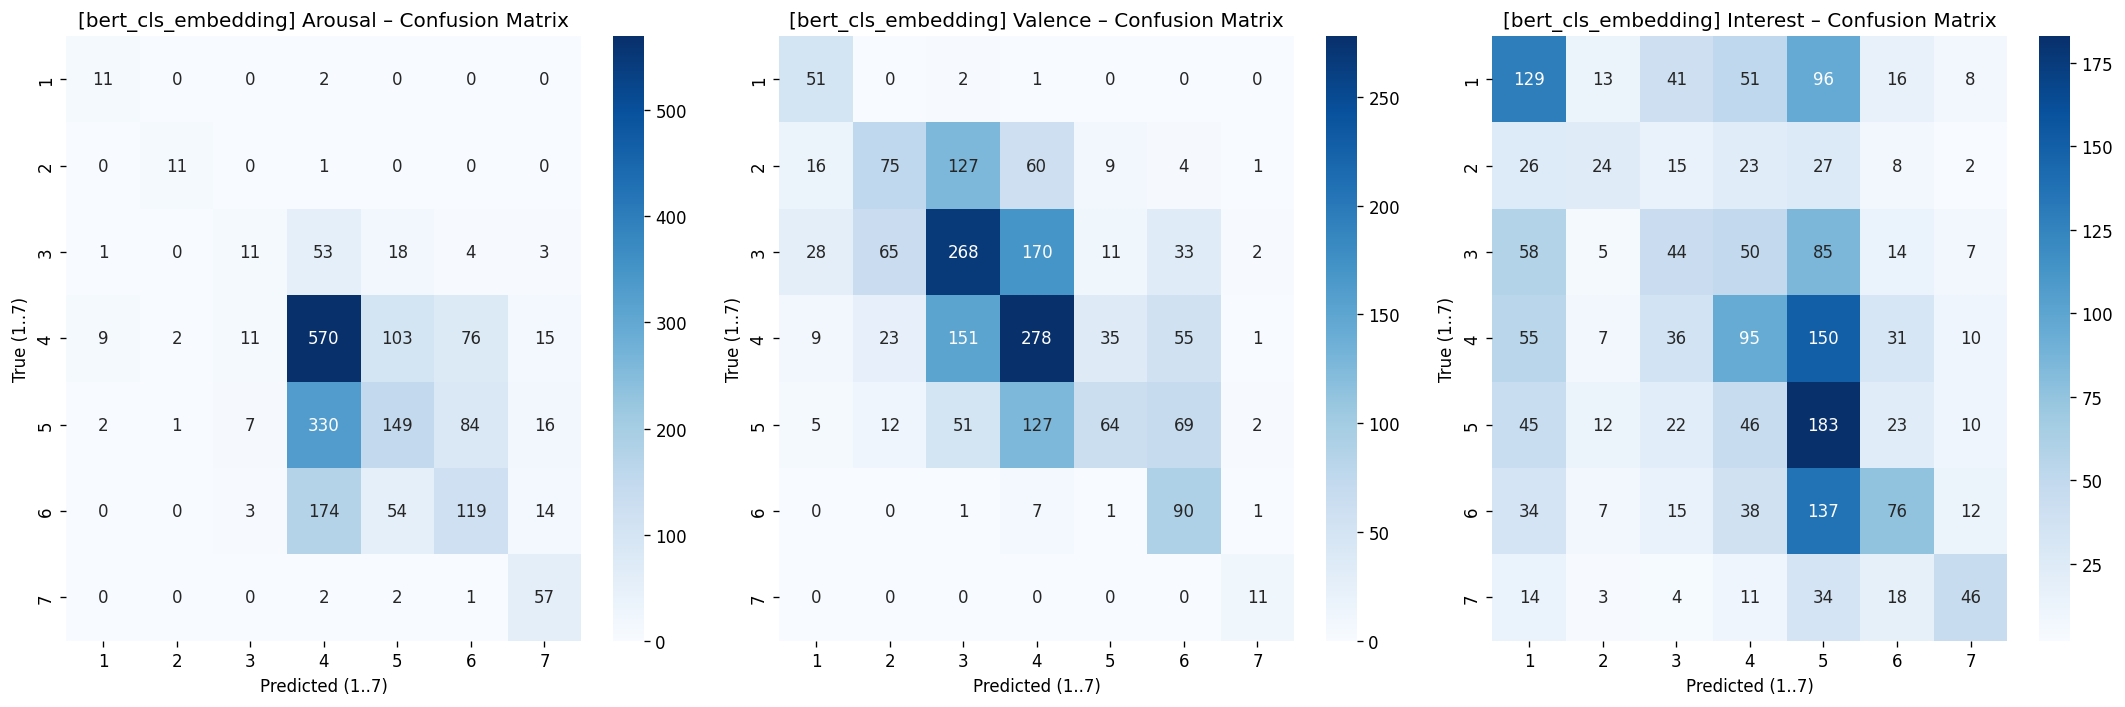


=== Training with embedding: bert_mean_embedding ===
[bert_mean_embedding] Ep 01 | TrainLoss 5.1083
[bert_mean_embedding] Ep 02 | TrainLoss 4.5798
[bert_mean_embedding] Ep 03 | TrainLoss 4.2272
[bert_mean_embedding] Ep 04 | TrainLoss 3.8734
[bert_mean_embedding] Ep 05 | TrainLoss 3.5417
[bert_mean_embedding] Ep 06 | TrainLoss 3.2367
[bert_mean_embedding] Ep 07 | TrainLoss 2.9960
[bert_mean_embedding] Ep 08 | TrainLoss 2.8062
[bert_mean_embedding] Ep 09 | TrainLoss 2.6231
[bert_mean_embedding] Ep 10 | TrainLoss 2.4774
Plotting confusion matrices for bert_mean_embedding ...


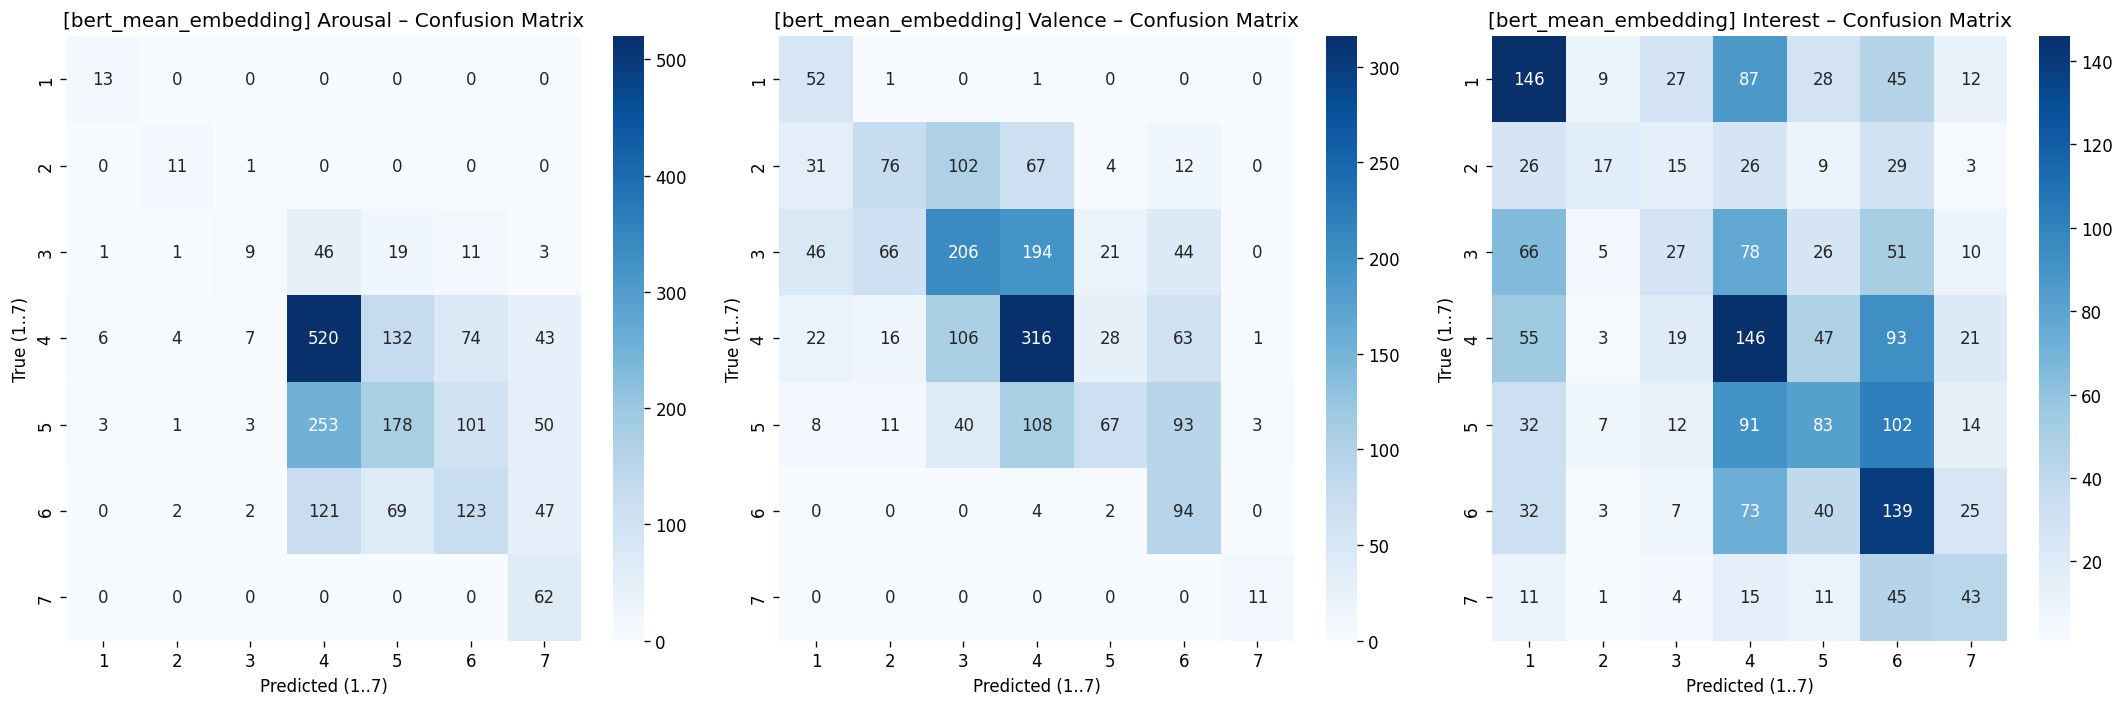


=== Training with embedding: sen_embedding_qwen0.6b ===
[sen_embedding_qwen0.6b] Ep 01 | TrainLoss 5.1764
[sen_embedding_qwen0.6b] Ep 02 | TrainLoss 4.4310
[sen_embedding_qwen0.6b] Ep 03 | TrainLoss 3.9598
[sen_embedding_qwen0.6b] Ep 04 | TrainLoss 3.5423
[sen_embedding_qwen0.6b] Ep 05 | TrainLoss 3.1793
[sen_embedding_qwen0.6b] Ep 06 | TrainLoss 2.8718
[sen_embedding_qwen0.6b] Ep 07 | TrainLoss 2.6322
[sen_embedding_qwen0.6b] Ep 08 | TrainLoss 2.4191
[sen_embedding_qwen0.6b] Ep 09 | TrainLoss 2.2493
[sen_embedding_qwen0.6b] Ep 10 | TrainLoss 2.0855
Plotting confusion matrices for sen_embedding_qwen0.6b ...


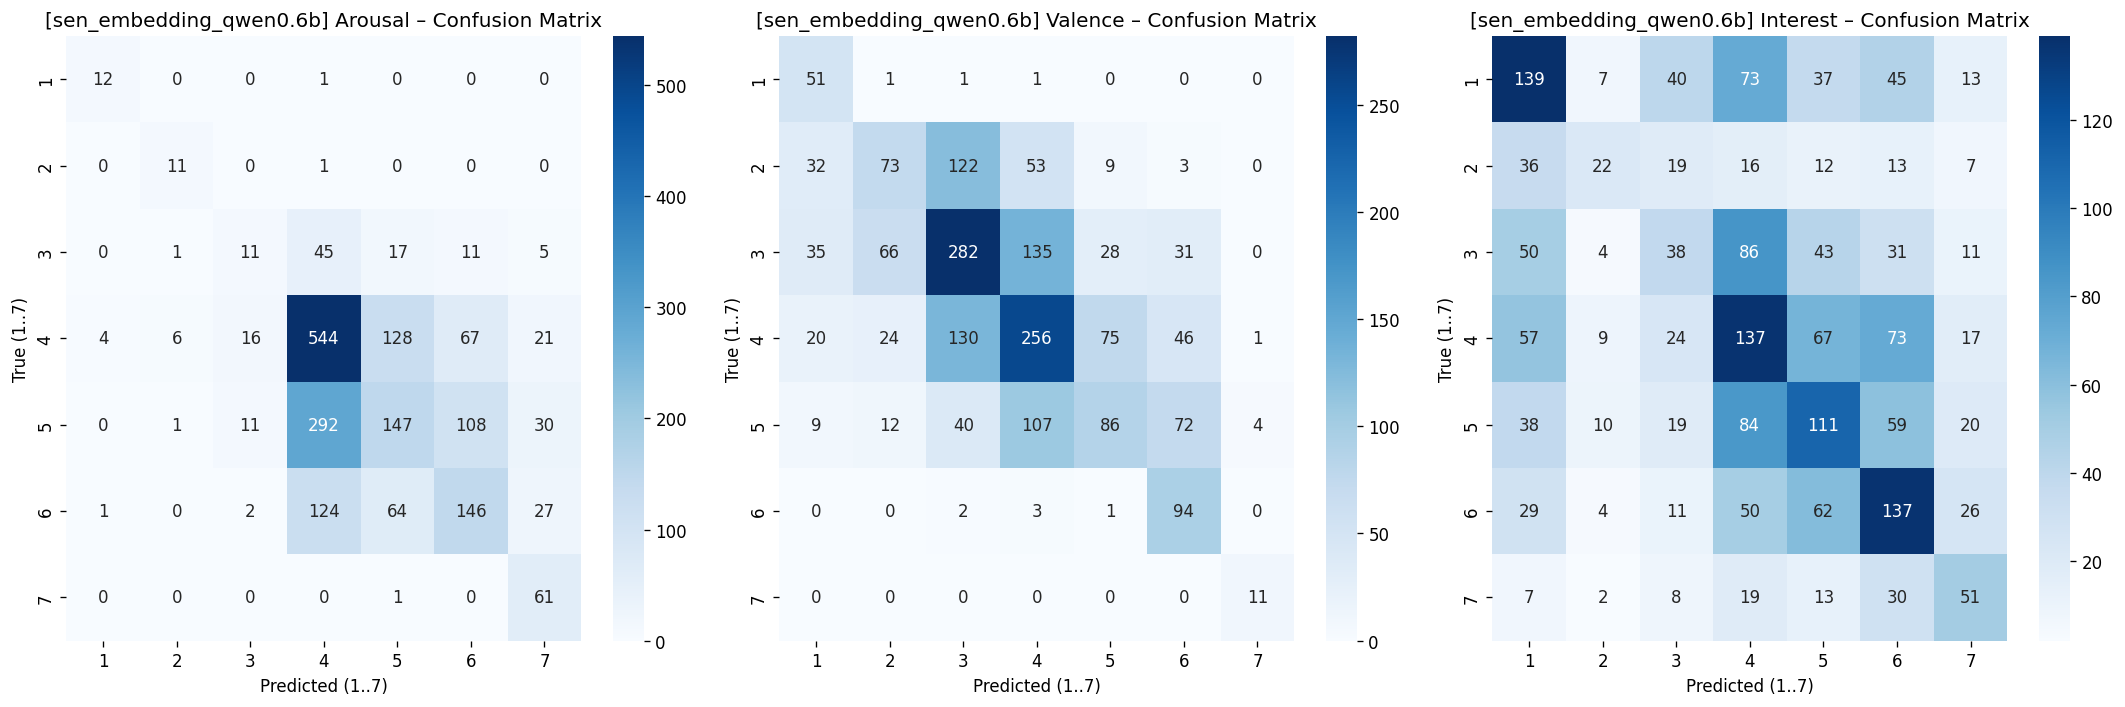


Plotting all training losses on a single figure ...


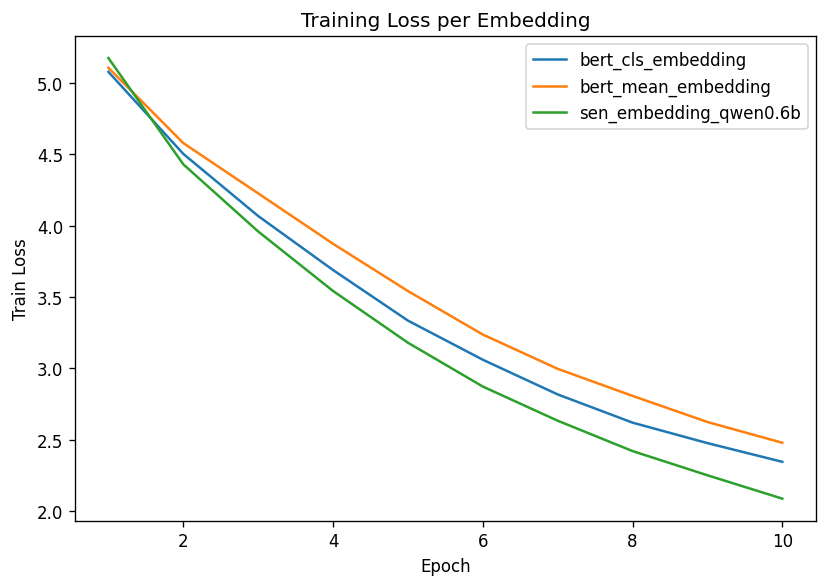

In [ ]:
set_seed(SEED)
train_df, test_df = make_train_test_no_aug(df_capped, test_size=0.15, seed=SEED)  # set unique_key if you have one
run_all_embeddings_on_splits(train_df, test_df)


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# --- config: must match your training run ---
EMB_KEYS = ("bert_cls_embedding", "bert_mean_embedding", "sen_embedding_qwen0.6b")
ARTIFACTS_DIR = "./artifacts"

# Columns in test_outputs.parquet (saved earlier)
Y_COLS   = {"arousal": "y_arousal",  "valence": "y_valence",  "interest": "y_interest"}
P_COLS   = {"arousal": "pred_arousal","valence": "pred_valence","interest": "pred_interest"}

def summarize_split(df, y_col, p_col):
    """Return dict of accuracy, macro/weighted F1, macro precision, macro recall."""
    y = df[y_col].to_numpy()          # 0..6
    p = df[p_col].to_numpy()          # 0..6

    acc = accuracy_score(y, p)
    # macro
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        y, p, average="macro", zero_division=0
    )
    # weighted
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
        y, p, average="weighted", zero_division=0
    )

    return {
        "acc": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_w,
        "prec_macro": prec_macro,
        "rec_macro": rec_macro,
        "prec_weighted": prec_w,
        "rec_weighted": rec_w,
    }

def build_embedding_comparison(emb_keys=EMB_KEYS, artifacts_dir=ARTIFACTS_DIR, round_ndigits=3):
    rows = []
    for emb in emb_keys:
        emb_dir = os.path.join(artifacts_dir, emb.replace("/", "_"))
        test_path = os.path.join(emb_dir, "test_outputs.parquet")
        if not os.path.exists(test_path):
            print(f"[WARN] Missing test outputs for {emb}: {test_path}")
            continue

        df_te = pd.read_parquet(test_path)

        # compute metrics per target
        metrics = {}
        for target in ("arousal", "valence", "interest"):
            m = summarize_split(df_te, Y_COLS[target], P_COLS[target])
            # prefix columns with target name
            for k, v in m.items():
                metrics[f"{target}_{k}"] = v

        metrics["embedding"] = emb
        rows.append(metrics)

    if not rows:
        raise RuntimeError("No embeddings found with test_outputs.parquet. Did you run training/artifacts?")

    out = pd.DataFrame(rows).set_index("embedding")

    # Order columns nicely
    col_order = []
    for target in ("arousal", "valence", "interest"):
        col_order += [
            f"{target}_acc",
            f"{target}_f1_macro",
            f"{target}_f1_weighted",
            f"{target}_prec_macro",
            f"{target}_rec_macro",
            # uncomment if you want to see weighted precision/recall too
            # f"{target}_prec_weighted",
            # f"{target}_rec_weighted",
        ]
    out = out[col_order].sort_index()

    # Round for readability
    out_rounded = out.copy().round(round_ndigits)

    # Save
    os.makedirs(artifacts_dir, exist_ok=True)
    csv_path = os.path.join(artifacts_dir, "embedding_comparison_metrics.csv")
    out_rounded.to_csv(csv_path)
    print(f"Saved comparison table to: {csv_path}")

    # Also save LaTeX (for paper/thesis)
    latex_path = os.path.join(artifacts_dir, "embedding_comparison_metrics.tex")
    with open(latex_path, "w") as f:
        f.write(out_rounded.to_latex(escape=True, bold_rows=False))
    print(f"Saved LaTeX table to: {latex_path}")

    return out_rounded

# === run ===
comparison_df = build_embedding_comparison()
print(comparison_df)


Saved comparison table to: ./artifacts/embedding_comparison_metrics.csv
Saved LaTeX table to: ./artifacts/embedding_comparison_metrics.tex
                        arousal_acc  arousal_f1_macro  arousal_f1_weighted  \
embedding                                                                    
bert_cls_embedding            0.484             0.515                0.454   
bert_mean_embedding           0.478             0.484                0.459   
sen_embedding_qwen0.6b        0.486             0.515                0.461   

                        arousal_prec_macro  arousal_rec_macro  valence_acc  \
embedding                                                                    
bert_cls_embedding                   0.504              0.587        0.437   
bert_mean_embedding                  0.465              0.617        0.429   
sen_embedding_qwen0.6b               0.482              0.613        0.445   

                        valence_f1_macro  valence_f1_weighted  \
embedding     

In [ ]:
# =========================
# Post-hoc analysis for basic CBM
# =========================
import os, json
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix
)

# ---- config: keep consistent with training ----
EMB_KEYS       = ("bert_cls_embedding", "bert_mean_embedding", "sen_embedding_qwen0.6b")
ARTIFACTS_DIR  = "./artifacts"
MODELS_DIR     = "./models"
NUM_CLASSES    = 7
N_BINS_ECE     = 15   # calibration bins

# Ensure plots are crisp
plt.rcParams["figure.dpi"] = 120

# ---------- helpers ----------
def _emb_safe(emb): return emb.replace("/", "_")

def load_test_bundle(emb):
    """Load test arrays + per-sample table for a given embedding."""
    base = os.path.join(ARTIFACTS_DIR, _emb_safe(emb))
    arrays = np.load(os.path.join(base, "test_arrays.npz"), allow_pickle=True)
    df     = pd.read_parquet(os.path.join(base, "test_outputs.parquet"))
    return arrays, df, base

def ece_score(y_true, probs, n_bins=15):
    """
    Expected Calibration Error (ECE) and Maximum Calibration Error (MCE).
    y_true: (N,) int labels 0..C-1
    probs:  (N,C) predicted probabilities
    """
    pred = probs.argmax(axis=1)
    conf = probs.max(axis=1)
    accs = (pred == y_true).astype(np.float32)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    mce = 0.0
    bin_stats = []
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (conf >= lo) & (conf < hi) if i < n_bins - 1 else (conf >= lo) & (conf <= hi)
        if mask.sum() == 0:
            bin_stats.append((lo, hi, 0, np.nan, np.nan))
            continue
        avg_conf = conf[mask].mean()
        avg_acc  = accs[mask].mean()
        gap = abs(avg_acc - avg_conf)
        ece += (mask.mean()) * gap
        mce = max(mce, gap)
        bin_stats.append((lo, hi, int(mask.sum()), float(avg_conf), float(avg_acc)))
    return float(ece), float(mce), pd.DataFrame(bin_stats, columns=["bin_lo","bin_hi","count","avg_conf","avg_acc"])

def plot_reliability(bin_df, title, out_png):
    plt.figure(figsize=(4.5,4.5), facecolor="white")
    # plot bars of avg_acc per bin and the diagonal
    mids = (bin_df["bin_lo"] + bin_df["bin_hi"]) / 2.0
    plt.bar(mids, bin_df["avg_acc"], width=(bin_df["bin_hi"] - bin_df["bin_lo"]), edgecolor="black", alpha=0.7)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_png)
    plt.close()

def summarize_split_df(df, y_col, p_col):
    """Return dict of accuracy, macro/weighted F1, macro precision, macro recall."""
    y = df[y_col].to_numpy()
    p = df[p_col].to_numpy()
    acc = accuracy_score(y, p)
    prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(y, p, average="macro", zero_division=0)
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(y, p, average="weighted", zero_division=0)
    return {
        "acc": acc, "f1_macro": f1_m, "f1_weighted": f1_w,
        "prec_macro": prec_m, "rec_macro": rec_m,
        "prec_weighted": prec_w, "rec_weighted": rec_w,
    }

def build_embedding_comparison(emb_keys=EMB_KEYS, artifacts_dir=ARTIFACTS_DIR, round_ndigits=3):
    rows = []
    for emb in emb_keys:
        emb_dir = os.path.join(artifacts_dir, _emb_safe(emb))
        test_path = os.path.join(emb_dir, "test_outputs.parquet")
        if not os.path.exists(test_path):
            print(f"[WARN] Missing test outputs for {emb}: {test_path}")
            continue
        df_te = pd.read_parquet(test_path)
        metrics = {}
        for target in ("arousal","valence","interest"):
            colmap = {
                "arousal": ("y_arousal","pred_arousal"),
                "valence": ("y_valence","pred_valence"),
                "interest":("y_interest","pred_interest")
            }
            m = summarize_split_df(df_te, *colmap[target])
            for k, v in m.items():
                metrics[f"{target}_{k}"] = v
        metrics["embedding"] = emb
        rows.append(metrics)
    if not rows:
        raise RuntimeError("No embeddings found with test_outputs.parquet.")
    out = pd.DataFrame(rows).set_index("embedding")
    col_order = []
    for t in ("arousal","valence","interest"):
        col_order += [f"{t}_acc", f"{t}_f1_macro", f"{t}_f1_weighted", f"{t}_prec_macro", f"{t}_rec_macro"]
    out = out[col_order].sort_index()
    out_rounded = out.round(round_ndigits)
    os.makedirs(artifacts_dir, exist_ok=True)
    out_rounded.to_csv(os.path.join(artifacts_dir, "embedding_comparison_metrics.csv"))
    with open(os.path.join(artifacts_dir, "embedding_comparison_metrics.tex"), "w") as f:
        f.write(out_rounded.to_latex(escape=True, bold_rows=False))
    return out_rounded

# ---------- CBM-specific attribution for INTEREST ----------
def load_interest_weight_blocks(state_dict_path, num_classes=NUM_CLASSES):
    """
    Pull the interest head weights/bias from a saved state_dict without rebuilding the module.
    Returns W_h, W_a, W_v, b, hidden_dim.
    """
    sd = torch.load(state_dict_path, map_location="cpu")
    W = sd["head_interest.weight"].detach().cpu().numpy()  # shape (C, hidden+2C)
    b = sd["head_interest.bias"].detach().cpu().numpy()    # shape (C,)
    hidden = W.shape[1] - 2 * num_classes
    W_h = W[:, :hidden]
    W_a = W[:, hidden:hidden+num_classes]
    W_v = W[:, hidden+num_classes:]
    return W_h, W_a, W_v, b, hidden

def logits_from_blocks(h, a_bn, v_bn, W_h, W_a, W_v, b):
    """
    Recompose interest logits from saved features/logits and linear blocks.
    PyTorch linear uses x @ W^T + b, so here we do:
    (h @ W_h^T) + (a_bn @ W_a^T) + (v_bn @ W_v^T) + b
    """
    out = h @ W_h.T + a_bn @ W_a.T + v_bn @ W_v.T
    out += b[None, :]
    return out

def make_onehot_like_logits(y, C, fill_value):
    z = np.zeros((len(y), C), dtype=np.float32)
    z[np.arange(len(y)), y.astype(int)] = fill_value
    return z

def interest_counterfactuals(arrays, state_dict_path):
    """
    Compute several variants for INTEREST:
    - full:      hidden + predicted A/V logits
    - hidden:    hidden only   (zero A/V)
    - concepts:  predicted A/V only (zero hidden)
    - oracle:    hidden + GT A/V one-hot logits (scaled to typical logit magnitude)
    Returns dict of (logits, preds, acc).
    """
    # unpack saved arrays
    h      = arrays["hidden"]                 # (N, hidden)
    a_bn   = arrays["a_bottleneck"]           # (N, C)
    v_bn   = arrays["v_bottleneck"]           # (N, C)
    y_i    = arrays["y_i"]                    # (N,)
    y_a    = arrays["y_a"]
    y_v    = arrays["y_v"]

    W_h, W_a, W_v, b, hidden = load_interest_weight_blocks(state_dict_path, num_classes=NUM_CLASSES)

    # full
    logits_full = logits_from_blocks(h, a_bn, v_bn, W_h, W_a, W_v, b)
    pred_full   = logits_full.argmax(axis=1)
    acc_full    = accuracy_score(y_i, pred_full)

    # hidden-only (zero concepts)
    zeros = np.zeros_like(a_bn)
    logits_hidden = logits_from_blocks(h, zeros, zeros, W_h, W_a, W_v, b)
    pred_hidden   = logits_hidden.argmax(axis=1)
    acc_hidden    = accuracy_score(y_i, pred_hidden)

    # concepts-only (zero hidden)
    zeros_h = np.zeros_like(h)
    logits_concepts = logits_from_blocks(zeros_h, a_bn, v_bn, W_h, W_a, W_v, b)
    pred_concepts   = logits_concepts.argmax(axis=1)
    acc_concepts    = accuracy_score(y_i, pred_concepts)

    # oracle concepts: replace a_bn/v_bn with GT one-hot logits at "typical" magnitude
    fill_a = np.median(np.max(np.abs(a_bn), axis=1))
    fill_v = np.median(np.max(np.abs(v_bn), axis=1))
    a_gt = make_onehot_like_logits(y_a, NUM_CLASSES, fill_a)
    v_gt = make_onehot_like_logits(y_v, NUM_CLASSES, fill_v)
    logits_oracle = logits_from_blocks(h, a_gt, v_gt, W_h, W_a, W_v, b)
    pred_oracle   = logits_oracle.argmax(axis=1)
    acc_oracle    = accuracy_score(y_i, pred_oracle)

    # weight attribution (norms): how much the head is wired to hidden vs A vs V
    contrib = {
        "W_h_l2": float(np.linalg.norm(W_h)),
        "W_a_l2": float(np.linalg.norm(W_a)),
        "W_v_l2": float(np.linalg.norm(W_v)),
    }
    total = contrib["W_h_l2"] + contrib["W_a_l2"] + contrib["W_v_l2"]
    if total > 0:
        contrib["frac_hidden"]  = contrib["W_h_l2"] / total
        contrib["frac_arousal"] = contrib["W_a_l2"] / total
        contrib["frac_valence"] = contrib["W_v_l2"] / total

    return {
        "acc_full": acc_full, "acc_hidden": acc_hidden, "acc_concepts": acc_concepts, "acc_oracle": acc_oracle,
        "pred_full": pred_full, "pred_hidden": pred_hidden, "pred_concepts": pred_concepts, "pred_oracle": pred_oracle,
        "logits_full": logits_full, "logits_hidden": logits_hidden, "logits_concepts": logits_concepts, "logits_oracle": logits_oracle,
        "contrib": contrib
    }

# ---------- main analysis runner ----------
def run_posthoc_analysis(emb_keys=EMB_KEYS):
    all_rows = []
    for emb in emb_keys:
        try:
            arrays, df, base = load_test_bundle(emb)
        except Exception as e:
            print(f"[WARN] skipping {emb}: {e}")
            continue

        # 1) Calibration for each target
        cal_dir = os.path.join(base, "analysis")
        os.makedirs(cal_dir, exist_ok=True)

        per_target = {
            "arousal": ("a_probs","y_a"),
            "valence": ("v_probs","y_v"),
            "interest":("i_probs","y_i"),
        }
        for name, (pkey, ykey) in per_target.items():
            ece, mce, bins = ece_score(arrays[ykey], arrays[pkey], n_bins=N_BINS_ECE)
            bins.to_csv(os.path.join(cal_dir, f"calibration_bins_{name}.csv"), index=False)
            plot_reliability(bins, f"{emb} – {name} reliability (ECE={ece:.3f})",
                             os.path.join(cal_dir, f"reliability_{name}.png"))
            all_rows.append({
                "embedding": emb, "target": name, "ECE": ece, "MCE": mce,
                "acc": accuracy_score(arrays[ykey], arrays[pkey].argmax(axis=1))
            })

        # 2) Interest head attributions / counterfactuals
        state_dict_path = os.path.join(MODELS_DIR, f"cbm_{_emb_safe(emb)}.pt")
        if os.path.exists(state_dict_path):
            cf = interest_counterfactuals(arrays, state_dict_path)
            # Save summary row
            all_rows.append({
                "embedding": emb, "target": "interest_cf",
                **{k: v for k, v in cf["contrib"].items()},
                "acc_full": cf["acc_full"],
                "acc_hidden": cf["acc_hidden"],
                "acc_concepts": cf["acc_concepts"],
                "acc_oracle": cf["acc_oracle"],
            })

            # Save confusion matrices for the variants (optional but handy)
            for variant, preds in [("full", cf["pred_full"]),
                                   ("hidden_only", cf["pred_hidden"]),
                                   ("concepts_only", cf["pred_concepts"]),
                                   ("oracle_concepts", cf["pred_oracle"])]:
                cm = confusion_matrix(arrays["y_i"], preds, labels=list(range(NUM_CLASSES)))
                fig, ax = plt.subplots(1,1, figsize=(5,4), facecolor="white")
                sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True, ax=ax)
                ax.set_title(f"{emb} – Interest CM ({variant})")
                ax.set_xlabel("Predicted (1..7)")
                ax.set_ylabel("True (1..7)")
                ax.set_xticklabels([str(i) for i in range(1, NUM_CLASSES+1)])
                ax.set_yticklabels([str(i) for i in range(1, NUM_CLASSES+1)])
                plt.tight_layout()
                plt.savefig(os.path.join(cal_dir, f"cm_interest_{variant}.png"))
                plt.close()

        else:
            print(f"[WARN] Missing model weights for {emb}: {state_dict_path}. Skipping interest CF analysis.")

    # Save global calibration/CF table
    if all_rows:
        df_summary = pd.DataFrame(all_rows)
        out_csv = os.path.join(ARTIFACTS_DIR, "posthoc_summary.csv")
        df_summary.to_csv(out_csv, index=False)
        print(f"[OK] Wrote: {out_csv}")
    else:
        print("[WARN] No results aggregated.")

    # 3) Rebuild & print the metrics comparison table (macro/weighted F1, acc)
    comp = build_embedding_comparison(emb_keys=emb_keys)
    print("\n=== Embedding comparison (macro/weighted F1 & acc) ===")
    print(comp)
    print(f"\nSaved to: {os.path.join(ARTIFACTS_DIR, 'embedding_comparison_metrics.csv')}")


In [ ]:
run_posthoc_analysis(EMB_KEYS)


[OK] Wrote: ./artifacts/posthoc_summary.csv

=== Embedding comparison (macro/weighted F1 & acc) ===
                        arousal_acc  arousal_f1_macro  arousal_f1_weighted  \
embedding                                                                    
bert_cls_embedding            0.484             0.515                0.454   
bert_mean_embedding           0.478             0.484                0.459   
sen_embedding_qwen0.6b        0.486             0.515                0.461   

                        arousal_prec_macro  arousal_rec_macro  valence_acc  \
embedding                                                                    
bert_cls_embedding                   0.504              0.587        0.437   
bert_mean_embedding                  0.465              0.617        0.429   
sen_embedding_qwen0.6b               0.482              0.613        0.445   

                        valence_f1_macro  valence_f1_weighted  \
embedding                                            

#Advanced CBM

In [ ]:
import torch
import torch.nn as nn

class ResidualMLP(nn.Module):
    """Pre-LN residual MLP block."""
    def __init__(self, hidden: int, expansion: int = 4, drop: float = 0.2):
        super().__init__()
        self.norm = nn.LayerNorm(hidden)
        self.fc1  = nn.Linear(hidden, hidden * expansion)
        self.act  = nn.GELU()
        self.drop = nn.Dropout(drop)
        self.fc2  = nn.Linear(hidden * expansion, hidden)
        self.drop2= nn.Dropout(drop)

    def forward(self, h: torch.Tensor) -> torch.Tensor:
        x = self.norm(h)
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return h + x

class AdvancedCBM(nn.Module):
    """
    shared -> (arousal_head, valence_head)
    interest_head gets [shared, stopgrad(arousal_logits), stopgrad(valence_logits)]
    """
    def __init__(
        self,
        in_dim: int,
        hidden: int = 256,
        num_classes: int = 7,
        drop: float = 0.2,
        n_blocks: int = 2,
        expansion: int = 4,
        bottleneck_drop: float = 0.1,
        detach_bottleneck: bool = True,
        input_noise_std: float = 0.0,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.detach_bottleneck = detach_bottleneck
        self.input_noise_std = float(input_noise_std)

        # Input projection + normalization
        self.in_norm = nn.LayerNorm(in_dim)
        self.in_proj = nn.Linear(in_dim, hidden)
        self.in_act  = nn.GELU()
        self.in_drop = nn.Dropout(drop)

        # Residual trunk
        blocks = [ResidualMLP(hidden, expansion=expansion, drop=drop) for _ in range(n_blocks)]
        self.trunk = nn.Sequential(*blocks)

        # Concept heads
        self.head_arousal = nn.Sequential(nn.LayerNorm(hidden), nn.Linear(hidden, num_classes))
        self.head_valence = nn.Sequential(nn.LayerNorm(hidden), nn.Linear(hidden, num_classes))

        # Interest head: shared + concept logits
        self.bottleneck_norm = nn.LayerNorm(hidden + 2 * num_classes)
        self.bottleneck_drop = nn.Dropout(bottleneck_drop)
        self.head_interest = nn.Sequential(
            nn.Linear(hidden + 2 * num_classes, hidden),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(hidden, num_classes),
        )

    def forward(self, x: torch.Tensor, return_features: bool = False):
        if self.training and self.input_noise_std > 0.0:
            x = x + torch.randn_like(x) * self.input_noise_std

        h = self.in_norm(x)
        h = self.in_proj(h)
        h = self.in_act(h)
        h = self.in_drop(h)
        h = self.trunk(h)

        a_logits = self.head_arousal(h)
        v_logits = self.head_valence(h)

        a_bn, v_bn = a_logits, v_logits
        if self.detach_bottleneck:
            with torch.no_grad():
                a_bn = a_bn.clone()
                v_bn = v_bn.clone()

        h_int = torch.cat([h, a_bn, v_bn], dim=1)
        h_int = self.bottleneck_norm(h_int)
        h_int = self.bottleneck_drop(h_int)
        i_logits = self.head_interest(h_int)

        if return_features:
            return a_logits, v_logits, i_logits, h, a_bn, v_bn
        return a_logits, v_logits, i_logits


In [ ]:
def train_one_model(train_df, test_df, emb_col,
                    epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR,
                    hidden=HIDDEN, num_classes=NUM_CLASSES,
                    label_smoothing=0.05,         # 0.0 to disable
                    loss_weights=(1.0, 1.0, 1.0), # (w_arousal, w_valence, w_interest)
                    use_cosine=True,
                    max_grad_norm=1.0,
                    input_noise_std=0.0,          # e.g., 0.02
                    n_blocks=2, expansion=4, drop=0.2, bottleneck_drop=0.1,
                    ):
    import math
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader

    _device = (DEVICE if "DEVICE" in globals()
               else (device if "device" in globals()
                     else ("cuda" if torch.cuda.is_available() else "cpu")))

    # Dataset / loaders
    in_dim = int(np.array(train_df[emb_col].iloc[0]).shape[0])
    ds_tr = CBMDataset(train_df, emb_col)
    ds_te = CBMDataset(test_df,  emb_col)
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=torch.cuda.is_available())
    dl_te = DataLoader(ds_te, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

    # Model
    model = AdvancedCBM(
        in_dim=in_dim,
        hidden=hidden,
        num_classes=num_classes,
        drop=drop,
        n_blocks=n_blocks,
        expansion=expansion,
        bottleneck_drop=bottleneck_drop,
        detach_bottleneck=True,
        input_noise_std=input_noise_std,
    ).to(_device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    crit = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    w_a, w_v, w_i = loss_weights

    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs) if use_cosine else None

    history = {"epoch": [], "train_loss": [], "loss_a": [], "loss_v": [], "loss_i": []}

    model.train()
    for ep in range(1, epochs + 1):
        tr_loss = la = lv = li = 0.0
        n_samples = 0

        for x, ya, yv, yi in dl_tr:
            x, ya, yv, yi = x.to(_device), ya.to(_device), yv.to(_device), yi.to(_device)

            a_logits, v_logits, i_logits = model(x)

            loss_a = crit(a_logits, ya)
            loss_v = crit(v_logits, yv)
            loss_i = crit(i_logits, yi)
            loss = w_a * loss_a + w_v * loss_v + w_i * loss_i

            opt.zero_grad(set_to_none=True)
            loss.backward()
            if max_grad_norm and max_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            opt.step()

            bs = x.size(0)
            tr_loss += loss.item() * bs
            la      += loss_a.item() * bs
            lv      += loss_v.item() * bs
            li      += loss_i.item() * bs
            n_samples += bs

        tr_loss /= max(1, n_samples)
        la /= max(1, n_samples); lv /= max(1, n_samples); li /= max(1, n_samples)
        history["epoch"].append(ep)
        history["train_loss"].append(tr_loss)
        history["loss_a"].append(la)
        history["loss_v"].append(lv)
        history["loss_i"].append(li)

        if sched is not None:
            sched.step()

        print(f"[{emb_col}] Ep {ep:02d} | TrainLoss {tr_loss:.4f} (A:{la:.4f} V:{lv:.4f} I:{li:.4f})")

    # Save final weights
    os.makedirs("./models", exist_ok=True)
    torch.save({k: v.cpu() for k, v in model.state_dict().items()}, f"./models/cbm_{emb_col.replace('/', '_')}.pt")

    import pandas as pd
    hist_df = pd.DataFrame(history)
    return model, hist_df, dl_tr, dl_te


In [ ]:
def run_all_embeddings_on_splits(train_df: pd.DataFrame, test_df: pd.DataFrame, **train_kwargs):
    """
    Train/evaluate across EMB_KEYS using the provided train/test splits.
    Saves artifacts, plots confusion matrices, and a single loss plot for all embeddings.
    Pass extra training kwargs to train_one_model via **train_kwargs.
    """
    os.makedirs("./models", exist_ok=True)
    os.makedirs("./artifacts", exist_ok=True)

    run_config = {
        "EPOCHS": EPOCHS, "BATCH_SIZE": BATCH_SIZE, "LR": LR,
        "WEIGHT_DECAY": WEIGHT_DECAY, "HIDDEN": HIDDEN, "SEED": SEED,
        "NUM_CLASSES": NUM_CLASSES, "EMB_KEYS": list(EMB_KEYS)
    }
    with open("./artifacts/run_config.json", "w") as f:
        json.dump(run_config, f, indent=2)

    loss_histories = {}

    for emb in EMB_KEYS:
        if emb not in train_df.columns:
            print(f"Skip {emb}: column not found in dataframe.")
            continue

        print(f"\n=== Training with embedding: {emb} ===")
        model, hist_df, dl_tr, dl_te = train_one_model(
            train_df, test_df, emb,
            epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR,
            hidden=HIDDEN, num_classes=NUM_CLASSES,
            **train_kwargs
        )
        loss_histories[emb] = hist_df

        # Save model
        model_path = f"./models/cbm_{emb.replace('/', '_')}.pt"
        torch.save({k: v.cpu() for k, v in model.state_dict().items()}, model_path)

        # Collect & save outputs
        print(f"Collecting TRAIN outputs for {emb} ...")
        train_arrays, train_df_out = collect_outputs(model, dl_tr, train_df, emb, split_name="train")

        print(f"Collecting TEST outputs for {emb} ...")
        test_arrays, test_df_out = collect_outputs(model, dl_te, test_df, emb, split_name="test")

        # Per-embedding artifacts
        emb_safe = emb.replace("/", "_")
        out_dir = f"./artifacts/{emb_safe}"
        os.makedirs(out_dir, exist_ok=True)

        hist_df.to_csv(f"{out_dir}/train_history.csv", index=False)
        np.savez_compressed(f"{out_dir}/train_arrays.npz", **train_arrays)
        np.savez_compressed(f"{out_dir}/test_arrays.npz",  **test_arrays)
        train_df_out.to_parquet(f"{out_dir}/train_outputs.parquet", index=False)
        test_df_out.to_parquet(f"{out_dir}/test_outputs.parquet",  index=False)

        # Confusion matrices (1x3) – white bg + Blues cmap
        print(f"Plotting confusion matrices for {emb} ...")
        plot_confusion_triplet(
            test_arrays["y_a"], test_arrays["a_pred"],
            test_arrays["y_v"], test_arrays["v_pred"],
            test_arrays["y_i"], test_arrays["i_pred"],
            title_prefix=f"[{emb}] "
        )

    print("\nPlotting all training losses on a single figure ...")
    plot_all_losses(loss_histories)


[Split] Final sizes -> Train=9893 | Test=1916 (target≈1916)

=== Training with embedding: bert_cls_embedding ===
[bert_cls_embedding] Ep 01 | TrainLoss 5.5061 (A:1.6327 V:1.6967 I:1.8139)
[bert_cls_embedding] Ep 02 | TrainLoss 4.8251 (A:1.3823 V:1.4299 I:1.6774)
[bert_cls_embedding] Ep 03 | TrainLoss 4.1468 (A:1.1575 V:1.1979 I:1.4929)
[bert_cls_embedding] Ep 04 | TrainLoss 3.6266 (A:1.0035 V:1.0540 I:1.3075)
[bert_cls_embedding] Ep 05 | TrainLoss 3.2032 (A:0.8841 V:0.9290 I:1.1584)
[bert_cls_embedding] Ep 06 | TrainLoss 2.8870 (A:0.7957 V:0.8403 I:1.0425)
[bert_cls_embedding] Ep 07 | TrainLoss 2.6597 (A:0.7338 V:0.7750 I:0.9591)
[bert_cls_embedding] Ep 08 | TrainLoss 2.4766 (A:0.6789 V:0.7225 I:0.8960)
[bert_cls_embedding] Ep 09 | TrainLoss 2.3463 (A:0.6446 V:0.6834 I:0.8486)
[bert_cls_embedding] Ep 10 | TrainLoss 2.2722 (A:0.6250 V:0.6618 I:0.8212)
Plotting confusion matrices for bert_cls_embedding ...


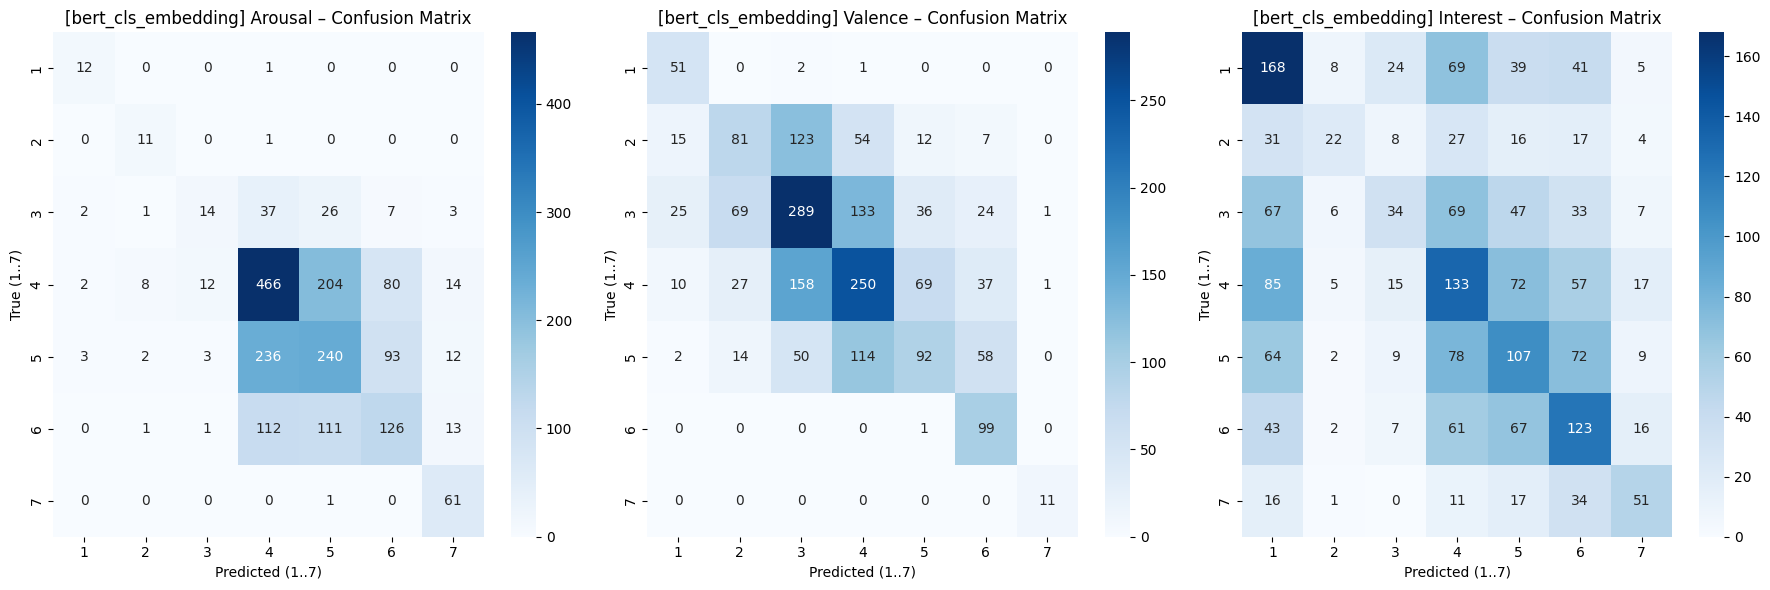


=== Training with embedding: bert_mean_embedding ===
[bert_mean_embedding] Ep 01 | TrainLoss 5.5725 (A:1.6546 V:1.7127 I:1.8377)
[bert_mean_embedding] Ep 02 | TrainLoss 4.9323 (A:1.4327 V:1.4577 I:1.7017)
[bert_mean_embedding] Ep 03 | TrainLoss 4.3352 (A:1.2210 V:1.2568 I:1.5479)
[bert_mean_embedding] Ep 04 | TrainLoss 3.7389 (A:1.0343 V:1.0731 I:1.3595)
[bert_mean_embedding] Ep 05 | TrainLoss 3.2553 (A:0.8912 V:0.9481 I:1.1800)
[bert_mean_embedding] Ep 06 | TrainLoss 2.9243 (A:0.8086 V:0.8464 I:1.0577)
[bert_mean_embedding] Ep 07 | TrainLoss 2.6708 (A:0.7329 V:0.7714 I:0.9721)
[bert_mean_embedding] Ep 08 | TrainLoss 2.4691 (A:0.6770 V:0.7095 I:0.9021)
[bert_mean_embedding] Ep 09 | TrainLoss 2.3482 (A:0.6394 V:0.6787 I:0.8584)
[bert_mean_embedding] Ep 10 | TrainLoss 2.2743 (A:0.6220 V:0.6551 I:0.8310)
Plotting confusion matrices for bert_mean_embedding ...


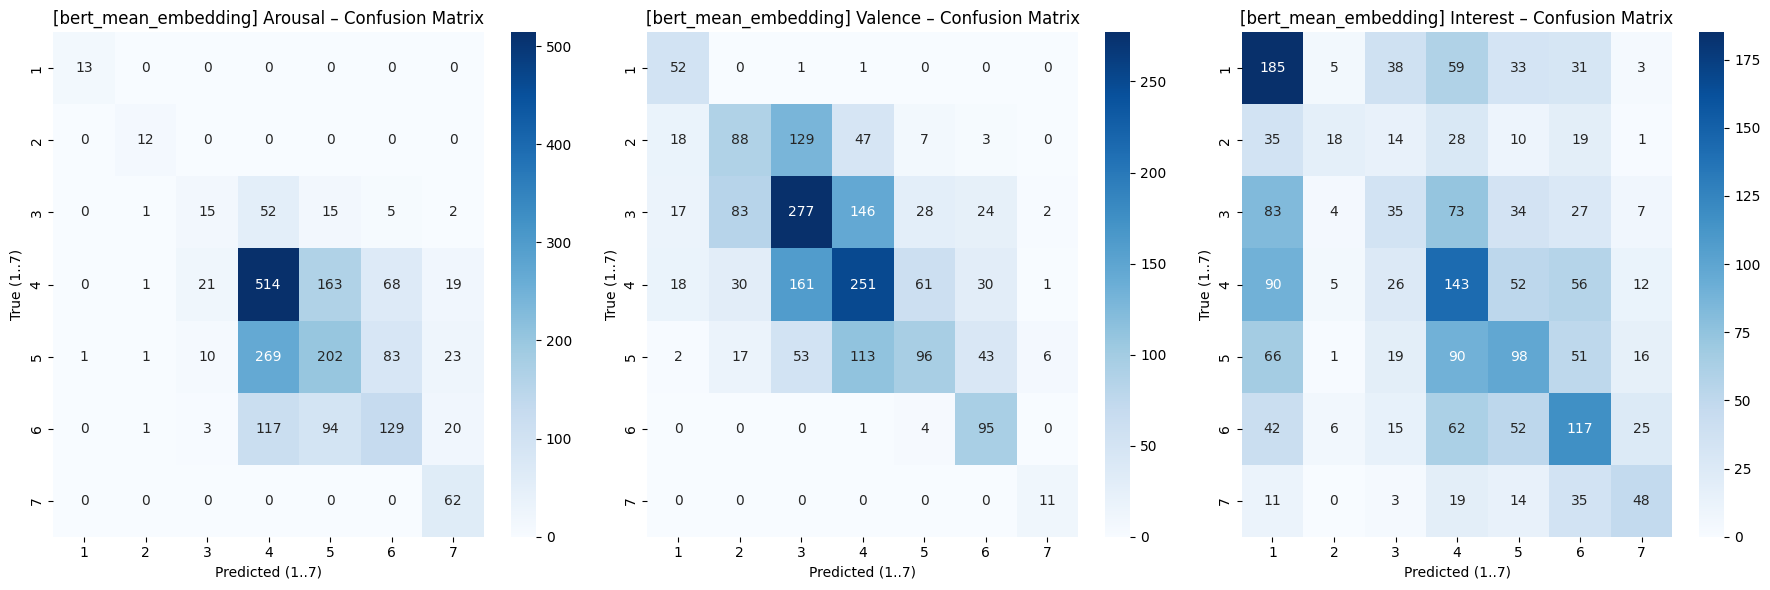


=== Training with embedding: sen_embedding_qwen0.6b ===
[sen_embedding_qwen0.6b] Ep 01 | TrainLoss 5.1620 (A:1.5219 V:1.5283 I:1.7599)
[sen_embedding_qwen0.6b] Ep 02 | TrainLoss 4.0898 (A:1.1454 V:1.1948 I:1.4581)
[sen_embedding_qwen0.6b] Ep 03 | TrainLoss 3.4211 (A:0.9463 V:0.9972 I:1.2313)
[sen_embedding_qwen0.6b] Ep 04 | TrainLoss 3.0720 (A:0.8464 V:0.8965 I:1.1076)
[sen_embedding_qwen0.6b] Ep 05 | TrainLoss 2.7997 (A:0.7677 V:0.8179 I:1.0118)
[sen_embedding_qwen0.6b] Ep 06 | TrainLoss 2.6246 (A:0.7233 V:0.7700 I:0.9428)
[sen_embedding_qwen0.6b] Ep 07 | TrainLoss 2.4679 (A:0.6811 V:0.7174 I:0.8911)
[sen_embedding_qwen0.6b] Ep 08 | TrainLoss 2.3444 (A:0.6466 V:0.6824 I:0.8461)
[sen_embedding_qwen0.6b] Ep 09 | TrainLoss 2.2670 (A:0.6312 V:0.6598 I:0.8133)
[sen_embedding_qwen0.6b] Ep 10 | TrainLoss 2.2152 (A:0.6081 V:0.6524 I:0.7956)
Plotting confusion matrices for sen_embedding_qwen0.6b ...


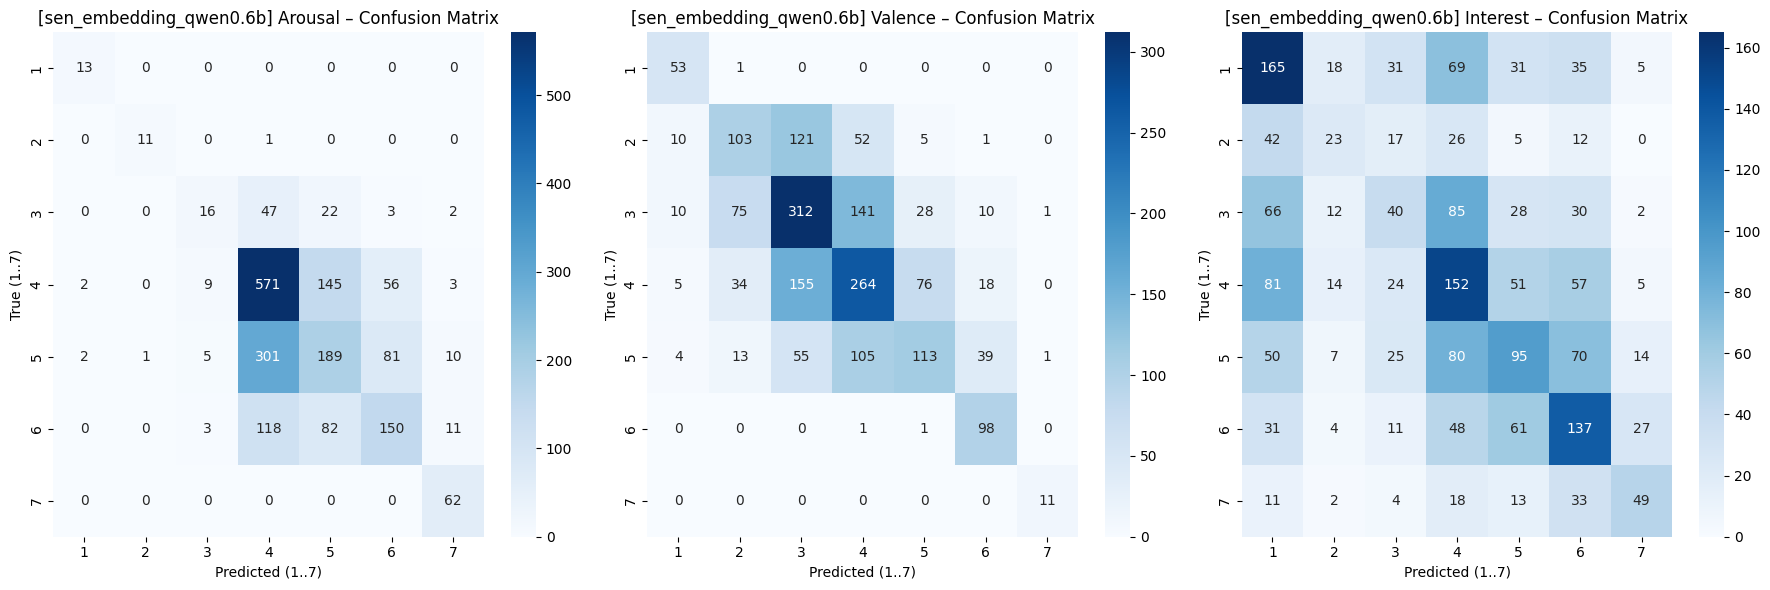


Plotting all training losses on a single figure ...


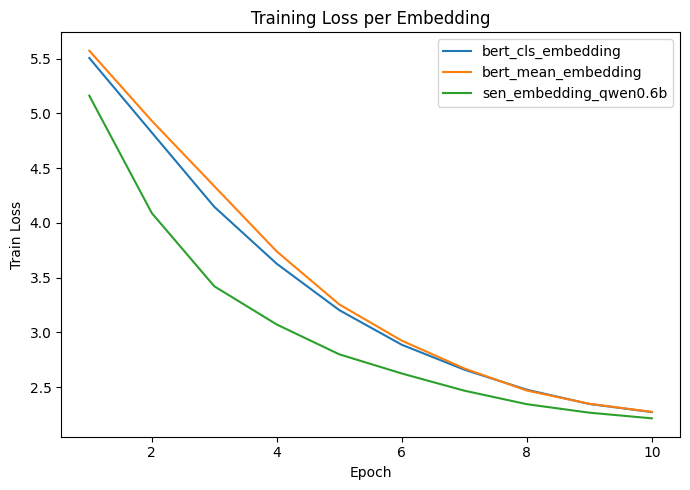

In [ ]:
# Build split with no augmentations in TEST (use your existing function)
set_seed(SEED)
train_df, test_df = make_train_test_no_aug(df_capped, test_size=0.15, seed=SEED)

# Optional: pick stronger defaults for the upgraded trainer
train_overrides = dict(
    label_smoothing=0.05,          # 0.0 to disable
    loss_weights=(1.0, 1.0, 1.2),  # emphasize interest a bit
    use_cosine=True,
    max_grad_norm=1.0,
    input_noise_std=0.02,          # light embedding noise (train-only)
    n_blocks=3,                    # deeper trunk
    expansion=4,
    drop=0.2,
    bottleneck_drop=0.1,
)

# Run all embeddings
run_all_embeddings_on_splits(train_df, test_df, **train_overrides)
